In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from os import path
import matplotlib.pylab as plt

from dual_controller_model_figures.plot import plot_functions as pf
from dual_controller_model_figures.utils import misc_utils as mu

### Performance

In [2]:
repo_path = path.abspath('.')

# output path for the plots
out_path = path.join(repo_path, 'output_plots')

# read the data
dual_model_file = path.join(repo_path, 'data/Intact_reward_100trails_1000timesteps.csv')
rpe_model_file = path.join(repo_path, 'data/NoTail_reward_100trails_1000timesteps.csv')
ape_model_file = path.join(repo_path, 'data/NoDorsal_reward_100trails_1000timesteps.csv')

dual_model = pd.read_csv(dual_model_file, header=None).to_numpy()
rpe_model = pd.read_csv(rpe_model_file, header=None).to_numpy()
ape_model = pd.read_csv(ape_model_file, header=None).to_numpy()

In [3]:
# cut the number of trials and adjust performance to 100
max_trials = 300
dual_model = np.array([100 * x[0:max_trials] for x in dual_model])
ape_model = np.array([100 * x[0:max_trials] for x in ape_model])
rpe_model = np.array([100 * x[0:max_trials] for x in rpe_model])

In [4]:
# rescale to match the 5000 experimental data
exp_data_ntrials = 5000
rescale_factor = int(np.ceil(exp_data_ntrials / max_trials))

xs = np.arange(0, max_trials)*rescale_factor

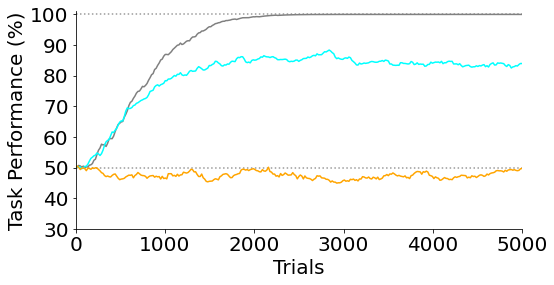

In [5]:
# continous monitoring of learning
fig1 = pf.make_figure_learning_across_trials(dual_model, rpe_model, ape_model, xs, show_std=False)
fig1.show()

plt.savefig(path.join(out_path, 'Performance_between_groups.pdf'),
            transparent=True, bbox_inches='tight')

In [13]:
# Subselect X agents to match experimental data sizes
n_agents = 12

dms = dual_model.copy()
rms = rpe_model.copy()

np.random.shuffle(dms)
dms = dms[0:n_agents, ]
np.random.shuffle(rms)
rms = rms[0:n_agents, ]

In [14]:
# bin trials as in the experimental
# The experiental datasets have 5000 trials and are binned every 100
# so 50 samples
nbins = 50
# average window
avg_window = int(np.floor(max_trials / nbins))
# empty lists to store values
dmsbin = []
rmsbin = []
# loop
for i in range(dms.shape[0]):
    dmsbin.append(mu.create_averages_by_window(dms[i], avg_window))
    rmsbin.append(mu.create_averages_by_window(rms[i], avg_window))

dmsbin = np.array(dmsbin)
rmsbin = np.array(rmsbin)

In [15]:
# calculate the differences between the models
model_diffs = np.mean(rmsbin, axis=0) - np.mean(dmsbin, axis=0)

In [16]:
# create shuffles of the data and calculate the
# differences of the means. Create a shuffled array of means
n_times = 10000
shuffled_arr = mu.generate_shuffled_means(np.concatenate([rmsbin, dmsbin]), n_times)

In [17]:
# calculate confidence intervals
top_ci = np.quantile(shuffled_arr, .95, axis=0)
bot_ci = np.quantile(shuffled_arr, .05, axis=0)

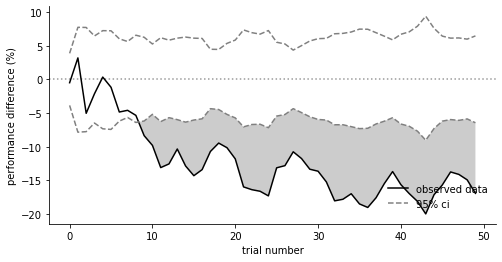

In [18]:
# plot differences and statistics
xsbin = range(dmsbin.shape[1])
fig2 = pf.make_figure_mean_differences_quantiles(model_diffs, top_ci, bot_ci, xsbin)
fig2.show()

plt.savefig(path.join(out_path, 'Differences_of_means_significance.pdf')
            ,transparent=True, bbox_inches='tight')

### Weights

In [16]:
# read data for the weights
tail_weights_file = path.join(repo_path, 'data/Intact_4weight_tail_100trails_1000timesteps.csv')
critic_weights_file = path.join(repo_path, 'data/Intact_4weight_critic_1000timesteps.csv')
actor_weights_file = path.join(repo_path, 'data/Intact_4weight_actor_1000timesteps.csv')

tailw = pd.read_csv(tail_weights_file, header=None).to_numpy()
criticw = pd.read_csv(critic_weights_file, header=None).to_numpy()
actorw = pd.read_csv(actor_weights_file, header=None).to_numpy()

In [17]:
# the data has 100 agents in it. Calculate the mean using an average of 100 (because of the weird data structure)
# empty lists to store values
tailwm = []
criticwm = []
actorwm = []
# loop
for i in range(tailw.shape[0]):
    tailwm.append(mu.create_averages_by_window(tailw[i], 100))
    criticwm.append(mu.create_averages_by_window(criticw[i], 100))
    actorwm.append(mu.create_averages_by_window(actorw[i], 100))

tailwm = np.array(tailwm)
criticwm = np.array(criticwm)
actorwm = np.array(actorwm)

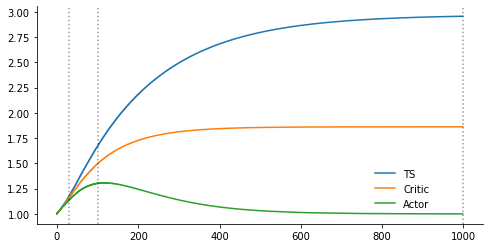

In [18]:
# plot the first weight of each
agents = [tailwm, criticwm, actorwm]
labels = ['TS', 'Critic', 'Actor']
it  = [30, 100, 1000]

fig3 = pf.make_figure_plot_x_weight_of_models(agents, labels, x=0, innact_times=it)
fig3.show()

plt.savefig(path.join(out_path, 'Weights.pdf')
            ,transparent=True, bbox_inches='tight')

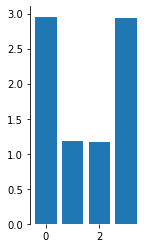

In [20]:
# Figure with the end weights for TS
# same correction as before to get the last weights
dataforbarplot = np.mean(tailw[:, -201:-101], axis=1)
xs = range(tailw.shape[0])

fig4 = pf.make_figure_weights_barplot(dataforbarplot, xs)
plt.savefig(path.join(out_path, 'TS_final_weights.pdf')
            ,transparent=True, bbox_inches='tight')
fig4.show()

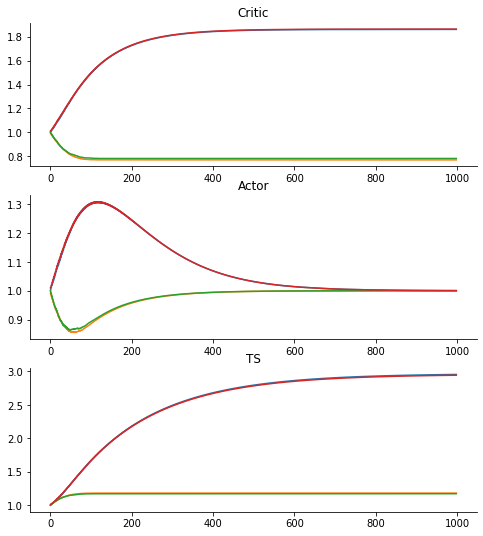

In [19]:
# plot all the weights for the supplementary
agents = [criticwm, actorwm, tailwm]
labels = ['Critic', 'Actor', 'TS']

fig5 = pf.make_figure_plot_all_weight_of_models(agents, labels)

plt.savefig(path.join(out_path, 'all_weights_suplementary.pdf')
            ,transparent=True, bbox_inches='tight')
fig5.show()

### Inactivations

In [21]:
# read data for the weights
tail_early_inactivation_file = path.join(repo_path, 'data/Inactivation_Tail_t30_reward_100trails_2000timesteps.csv')
t_early = pd.read_csv(tail_early_inactivation_file, header=None).to_numpy()

tail_mid_inactivation_file = path.join(repo_path, 'data/Inactivation_Tail_t100_reward_100trails_2000timesteps.csv')
t_mid = pd.read_csv(tail_mid_inactivation_file, header=None).to_numpy()

tail_late_inactivation_file = path.join(repo_path, 'data/Inactivation_Tail_t1000_reward_100trails_2000timesteps.csv')
t_late = pd.read_csv(tail_late_inactivation_file, header=None).to_numpy()

dorsal_early_inactivation_file = path.join(repo_path, 'data/Inactivation_Dorsal_t30_reward_100trails_2000timesteps.csv')
d_early = pd.read_csv(dorsal_early_inactivation_file, header=None).to_numpy()

dorsal_mid_inactivation_file = path.join(repo_path, 'data/Inactivation_Dorsal_t100_reward_100trails_2000timesteps.csv')
d_mid = pd.read_csv(dorsal_mid_inactivation_file, header=None).to_numpy()

dorsal_late_inactivation_file = path.join(repo_path, 'data/Inactivation_Dorsal_t1000_reward_100trails_2000timesteps.csv')
d_late = pd.read_csv(dorsal_late_inactivation_file, header=None).to_numpy()

In [22]:
# quantify performance before and after inactivations as the mean of the previous / following X trials
x_tr_before = 1
spacer_trials = 10
x_tr_after = 700

# inactivation times
early_in_time = 30
mid_in_time = 100
late_in_time = 1000

intact_early_perf = 100 * np.mean(np.mean(d_early, axis=0)[(early_in_time - x_tr_before - 1):(early_in_time - 1)])
tail_early_perf = 100 * np.mean(np.mean(t_early, axis=0)[(early_in_time + spacer_trials):(early_in_time + spacer_trials + x_tr_after)])
dorsal_early_perf = 100 * np.mean(np.mean(d_early, axis=0)[(early_in_time + spacer_trials):(early_in_time + spacer_trials + x_tr_after)])

intact_mid_perf = 100 * np.mean(np.mean(d_mid, axis=0)[(mid_in_time - x_tr_before - 1):(mid_in_time - 1)])
tail_mid_perf = 100 * np.mean(np.mean(t_mid, axis=0)[(mid_in_time + spacer_trials):(mid_in_time + spacer_trials + x_tr_after)])
dorsal_mid_perf = 100 * np.mean(np.mean(d_mid, axis=0)[(mid_in_time + spacer_trials):(mid_in_time + spacer_trials + x_tr_after)])

intact_late_perf = 100 * np.mean(np.mean(d_late, axis=0)[(late_in_time - x_tr_before - 1):(late_in_time - 1)])
tail_late_perf = 100 * np.mean(np.mean(t_late, axis=0)[(late_in_time + spacer_trials):(late_in_time + spacer_trials + x_tr_after)])
dorsal_late_perf = 100 * np.mean(np.mean(d_late, axis=0)[(late_in_time + spacer_trials):(late_in_time + spacer_trials + x_tr_after)])

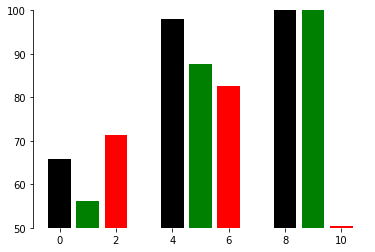

In [26]:
# define the data for the plot
dataforbarplot = [intact_early_perf, dorsal_early_perf, tail_early_perf,
                  intact_mid_perf, dorsal_mid_perf, tail_mid_perf,
                  intact_late_perf, dorsal_late_perf, tail_late_perf]

# spacing of bars
xs = [0,1,2,4,5,6,8,9,10]

# colors
cols = ['k', 'g', 'r'] * 3

# make plot

fig6 = pf.make_figure_innactivation_performance(xs, dataforbarplot, cols)
fig6.show()
plt.savefig(path.join(out_path, 'Inactivations.pdf')
            ,transparent=True, bbox_inches='tight')

In [ ]:
# # there are some weird irregularities in the datasets:
# # all the agents behave similar overall
# dms = dual_model.copy()
# rms = rpe_model.copy()
# for i in range(500):
#     np.random.shuffle(dms)
#     np.random.shuffle(rms)
#     plt.plot(xs, np.mean(dms[0:10, ], axis=0), color='blue', alpha=.01)
#     plt.plot(xs, np.mean(rms[0:10, ], axis=0), color='orange', alpha=.01)

In [ ]:
# # do this several times to see how the randomness behaves
# n_agents = 10

# for i in range(50):
#     dms = dual_model.copy()
#     rms = rpe_model.copy()

#     np.random.shuffle(dms)
#     dms = dms[0:n_agents, ]
#     np.random.shuffle(rms)
#     rms = rms[0:n_agents, ]
#     # plot differences
#     model_diffs = np.mean(dms, axis=0) - np.mean(rms, axis=0)
#     plt.plot(xs, model_diffs, alpha=.1, color='k')
# plt.show()